In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import sys
sys.path.append("../")
from agg_utils.path_conf import loc_data_dir
from plotly_resampler.aggregation.algorithms.lttb_py import LTTB_core_py
from plotly_resampler.aggregation.aggregators import MinMaxAggregator
from plotly_resampler import FigureResampler
# from tsdownsample import MinMaxDownsampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# read in the agg data csv from `0.2_create_agg_data.ipynb` and construct the
# corresponding dicts which will be used by the visualization toolkits to operate upon
df_agg_data = pd.read_csv(loc_data_dir / "agg_data_preselect.csv")


In [21]:
n_out_mask = pd.isna(df_agg_data.n_out)
lttb_mask = df_agg_data.aggregator == "LTTB"

def read_set_index_first_col(pqt_path) -> pd.Series:
    df = pd.read_parquet(pqt_path)
    df = df.set_index(df.columns[0], drop=True)
    assert len(df.columns) == 1
    return df.iloc[:, 0]

ref_data_dict = {
    f"{r.data}_{r.aggregator}_{r.n}": read_set_index_first_col(r.path)
    for _, r in tqdm(df_agg_data[n_out_mask].iterrows(), total=sum(n_out_mask))
}

  0%|          | 0/18 [00:00<?, ?it/s]

In [22]:
def get_offsets(n, n_out) -> np.ndarray:
    """Compute the offsets for the LTTB algorithm, which we can extract from the datapoints."""
    # Bucket size. Leave room for start and end data points
    block_size = (n - 2) / (n_out - 2)
    # Note this 'astype' cast must take place after array creation (and not with the
    # aranage() its dtype argument) or it will cast the `block_size` step to an int
    # before the arange array creation
    offsets = np.arange(start=1, stop=n, step=block_size).astype(np.int64)
    return offsets

In [23]:
def get_rel_bucket_series(key, agg_series) -> pd.Series:
    """Compute the relative bucketed series."""
    data, agg, n, n_out = key.split("_")[:4]
    ref_series = ref_data_dict[f"{data}_reference_{n}"]
    offsets = get_offsets(int(n), int(n_out))
    delta = offsets[1] - offsets[0]
    return pd.Series(
        index=agg_series.iloc[1:-1].index - ref_series.iloc[offsets].index[:-1],
        data=agg_series.values[1:-1],
    ), delta


## LTTB

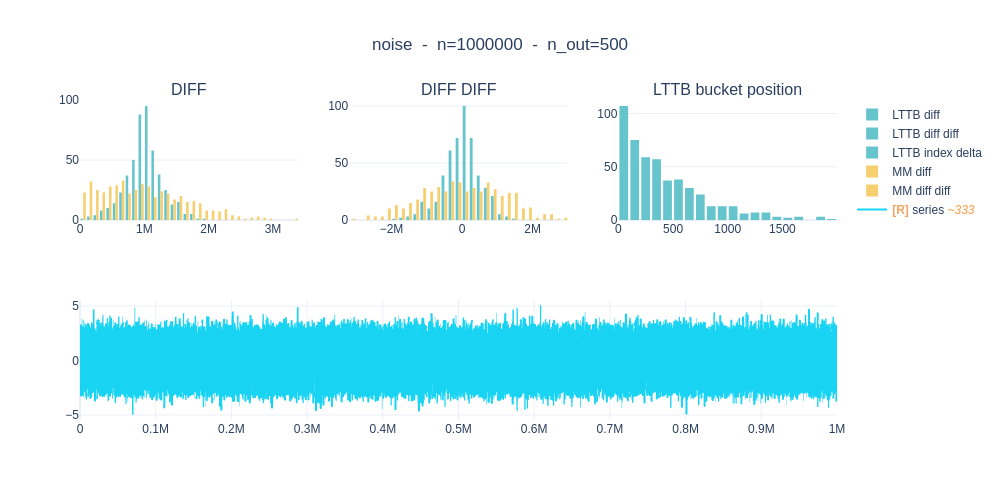

In [26]:
data = "noise"
n = 1_000_000
n_out = 500

# fmt: off
ref_series = ref_data_dict[f"{data}_reference_{n}"]
if isinstance(ref_series.index, pd.DatetimeIndex):
    ref_series.index = ref_series.index.view(np.int64) // 1_000_000
offsets = get_offsets(n, n_out)[:-1]
sampled_x_lttb = LTTB_core_py.downsample(ref_series.index, ref_series.values, n_out)[1:-1]
delta = offsets[1] - offsets[0]
sampled_index_mm = MinMaxAggregator()._aggregate(ref_series, n_out=n_out)[1:-1].index
sampled_index_lttb = ref_series.index[sampled_x_lttb]
agg_series_delta = sampled_x_lttb - offsets


palette = px.colors.qualitative.Pastel
fig = FigureResampler(
    make_subplots(rows=2, cols=3, specs=[[{}, {}, {},], [{"colspan": 3}, None, None]],
                  subplot_titles=['DIFF', 'DIFF DIFF', 'LTTB bucket position']
    ), default_n_shown_samples=3000)
fig.add_trace(go.Histogram(x=sampled_index_lttb.to_series().diff().values[2:-2] * n_out, name='LTTB diff', marker_color=palette[0]), col=1, row=1)
fig.add_trace(go.Histogram(x=sampled_index_lttb.to_series().diff().diff().values[2:-2] * n_out, name='LTTB diff diff', marker_color=palette[0]), col=2, row=1)
fig.add_trace(go.Histogram(x=agg_series_delta, name='LTTB index delta', marker_color=palette[0]), col=3, row=1, )
if True:
    fig.add_trace(go.Histogram(x=sampled_index_mm.to_series().diff().values[2:-2] * n_out, name='MM diff', marker_color=palette[1]), col=1, row=1)
    fig.add_trace(go.Histogram(x=sampled_index_mm.to_series().diff().diff().values[2:-2] * n_out, name='MM diff diff', marker_color=palette[1]), col=2, row=1)
fig.add_trace(go.Scattergl(name='series'), hf_x=ref_series.index, hf_y=ref_series.values, col=1, row=2, downsampler=MinMaxAggregator())
fig.update_layout(template='plotly_white', title=f"{data}  -  n={n}  -  n_out={n_out}", title_x=0.5, height=500)
fig.show(renderer='png', width=1000, height=500)


As can be observed from the above plot: 
- LTTB seems to favor selecting datapoints from the LEFT side of the bucket. (i.e. right upper plot)
- LTTB's selected datapoints seem to be more equidistant than MinMax (MM) (i.e. middle and left upper plot)

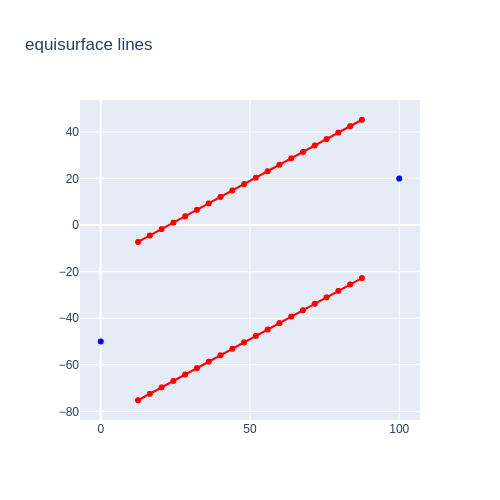

In [32]:
# triangular surface curve
# find the y-values between two fixed coordinates which give the same triangle area
ax, ay = 0, -50 
mean_next_x, mean_next_y = 100, 20
dx = mean_next_x - ax

surface_value = ((mean_next_x - ax) + (mean_next_y - ay)) * 20


def find_y_for_surface_value(prev_x, prev_y, avg_next_x, avg_next_y, x_bucket, surface, sign=1):
    # NO abs -> so we find surface values for only one side of the triangle
    return (
        (
            surface
            - x_bucket * (prev_y - avg_next_y)
            - (prev_x * avg_next_y - avg_next_x * prev_y)
        )
    ) / (avg_next_x - prev_x)

xs = np.linspace(dx/8, mean_next_x - dx/8, 20)
ys = [find_y_for_surface_value(ax, ay, mean_next_x, mean_next_y, x, surface_value) for x in xs]
neg_ys = [find_y_for_surface_value(ax, ay, mean_next_x, mean_next_y, x, -surface_value) for x in xs]
ys

fig = go.Figure()
fig.add_trace(go.Scatter(x=[ax, mean_next_x], y=[ay, mean_next_y], mode='markers', showlegend=False, marker_color='blue'))
fig.add_trace(go.Scatter(x=xs, y=ys, mode='markers+lines', line_color='red', showlegend=False))
fig.add_trace(go.Scatter(x=xs, y=neg_ys, mode='markers+lines', line_color='red', showlegend=False))
fig.update_layout(title='equisurface lines').show(renderer='png', width=500, height=500)

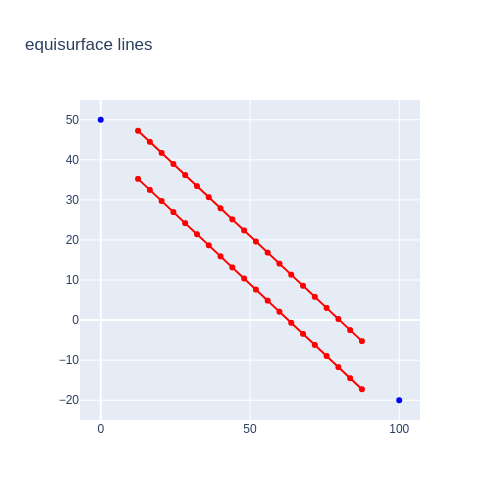

In [33]:
# triangular surface curve
# find the y-values between two fixed coordinates which give the same triangle area
ax, ay = 0, 50 
mean_next_x, mean_next_y = 100, -20
dx = mean_next_x - ax

surface_value = ((mean_next_x - ax) + (mean_next_y - ay)) * 20

xs = np.linspace(dx/8, mean_next_x - dx/8, 20)
ys = [find_y_for_surface_value(ax, ay, mean_next_x, mean_next_y, x, surface_value) for x in xs]
neg_ys = [find_y_for_surface_value(ax, ay, mean_next_x, mean_next_y, x, -surface_value) for x in xs]

fig = go.Figure()
fig.add_trace(go.Scatter(x=[ax, mean_next_x], y=[ay, mean_next_y], mode='markers', showlegend=False, marker_color='blue'))
fig.add_trace(go.Scatter(x=xs, y=ys, mode='markers+lines', line_color='red', showlegend=False))
fig.add_trace(go.Scatter(x=xs, y=neg_ys, mode='markers+lines', line_color='red', showlegend=False))
fig.update_layout(title='equisurface lines').show(renderer='png', width=500, height=500)

## Matplotlib paper figure

In [34]:
import matplotlib.pyplot as plt

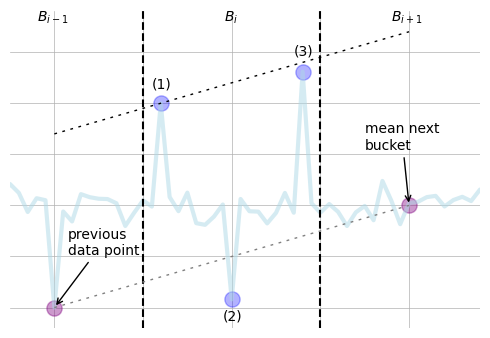

In [36]:
bucket_size = 20 
x0, y0 = 10, 5
avg_next_x, avg_next_y = 2.5 * bucket_size,15 

# the datapoint with the largest triangular surface
x1, y1 = bucket_size + 2, 25 

# the line between the first point and the avg next point
rico = (avg_next_y - y0) / (avg_next_x - x0)

# the point with a slightly smaller triangular surface
x2 = 2 * bucket_size -2
y2 = (x2 - x1) * rico + y1 - .9


# draw a dotted line from the last point to the avg next point
data = pd.Series(index=np.arange(3 * bucket_size), data=15 + np.random.randn(3 * bucket_size))
data[x0] = y0
data[x1] = y1
data[(x1 + x2) // 2] = 5.8
data[x2] = y2

xs = data.index
ys = data.values

fig, ax = plt.subplots(figsize=(5, 3.5))
ax.plot(xs, ys, alpha=0.5, color='lightblue', lw=3)
# vertical lines for the buckets
ax.axvline(x=bucket_size, color='black', linestyle='--', linewidth=1.5)
ax.axvline(x=2 * bucket_size, color='black', linestyle='--', linewidth=1.5)

ax.scatter([x0, avg_next_x], [y0, avg_next_y], color='purple', alpha=0.4, s=120)
ax.scatter([x1, x2, ((x1 + x2) // 2)], [y1, y2, 5.8], color='blue', alpha=0.3, s=120)
ax.annotate('(1)', (x1, y1), (x1 - 1, y1 + 1.5))
ax.annotate('(2)', (x1 + x2 // 2, 5.8), ((x1 + x2) // 2 - 1, 3.8))
ax.annotate('(3)', (x2, y2), (x2 - 1, y2 + 1.6))

ax.plot([x0, avg_next_x], [y0, avg_next_y], color='gray', linestyle=(0, (2, 4)), linewidth=1)
ax.plot([x0, avg_next_x], [y1 - rico * (x1 - x0),  y1 + rico * (avg_next_x - x1)], color='black', linestyle=(0, (2, 4)), linewidth=1)

ax.annotate('mean next\nbucket', (avg_next_x, avg_next_y), (avg_next_x - 5, avg_next_y + 5.5), arrowprops=dict(arrowstyle='->'))
ax.annotate('previous\ndata point', (x0, y0), (x0 + 1.5, y0 + 5.2), arrowprops=dict(arrowstyle='->'))

bucket_y = 33
ax.annotate('$B_{i-1}$', (bucket_size/2.5, bucket_y), (bucket_size/2.5, bucket_y))
ax.annotate('$B_{i}$', (bucket_size + bucket_size/2.2, bucket_y), (bucket_size + bucket_size/2.2, bucket_y))
ax.annotate('$B_{i+1}$', (2* bucket_size + bucket_size/2.5, bucket_y), (2 * bucket_size + bucket_size/2.5, bucket_y))
# ax.annotate('$B_{i-1}$', (bucket_size/1.9, bucket_y), (bucket_size/1.9, bucket_y))
# ax.annotate('$B_{i}$', (bucket_size + bucket_size/1.96, bucket_y), (bucket_size + bucket_size/1.96, bucket_y))
# ax.annotate('$B_{i+1}$', (2* bucket_size + bucket_size/3, bucket_y), (2 * bucket_size + bucket_size/3, bucket_y))
ax.set_xlim(5, 3 * bucket_size - 2)
ax.set_ylim(3, bucket_y + 1)


# only show the x line
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)
# show the grid without the ticks
ax.grid(visible=True)
# set the grid width 
ax.grid(lw=0.5)
ax.set_frame_on(False)
# put the grid behind the data
ax.set_axisbelow(True)

# disable the ticks, but keep the grid
for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)

plt.tight_layout()
plt.show()
fig.savefig('../reports/bucket.pdf', dpi=300)
